In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print(sys.version)

3.13.2 | packaged by conda-forge | (main, Feb 17 2025, 14:10:22) [GCC 13.3.0]


In [2]:
os.chdir('../..')

In step 3 we create a set of downsampled datasets over a grid of parameter. Configuration include: 

* parameters to match the BEELINE - like workflow: a list of TFs, a file with reference network, number of top HVGs and whether to use TFs

* parameters for the downsampling: granularity of the grid

In [3]:

# Run it:
# ─── Config ────────────────────────────────────────────────────────────────────

tf_file = 'data/human-tfs.csv'
network_file = 'data/9606_protein_links_gene_names_combined_score_700.csv'
network_name = 'STRING12'
beeline_dir = 'BEELINE/'
beeline_dir = Path(beeline_dir)


dataset_name = 'buenrostro18'
n_top_hvg = 1000
include_hv_tfs = True
tfs_suffix = 'TFs' if include_hv_tfs else ''
output_dir = beeline_dir / 'inputs' / dataset_name
os.makedirs(output_dir, exist_ok=True)

cfg = {
    'tf_file': tf_file,
    'network_file': network_file,
    'network_name': network_name,
    'output_dir': output_dir,
    'dataset_name': dataset_name,
    'cell_fracs': np.linspace(0.1, 1.0, 10),
    'read_fracs': np.linspace(0.1, 1.0, 10),
    'seed': 420,
    'n_top_hvg': n_top_hvg,
    'include_hv_tfs': include_hv_tfs,
}

all_known_tfs = pd.read_csv(cfg['tf_file'], header=None).iloc[:,0].tolist()
net_df = pd.read_csv(cfg['network_file'])

## LOAD

After thiss step we need an AnnData object after quality control, but before normalization and logarithmization.

In [4]:
adata_path  = 'BEELINE/inputs/buenrostro18/buenrostro18.h5ad'
adata_rna = sc.read(adata_path)
adata_rna.X = adata_rna.layers['counts'].copy()

In [5]:
print(f"Initial AnnData shape: {adata_rna.shape}") # (cells, genes)

print(f"Reading TF list: {tf_file}")
tfs_df = pd.read_csv(tf_file, header=0)
all_known_tfs = set(tfs_df[tfs_df.columns[0]])

print(f"Reading network: {network_file}")
net_df = pd.read_csv(network_file)
print(f"Initial network shape: {net_df.shape}")


Initial AnnData shape: (13779, 12558)
Reading TF list: /home/kl467102/Beeline-238/inputs/hHep/human-tfs.csv
Reading network: /home/kl467102/string_dir/9606_protein_links_gene_names_combined_score_700.csv
Initial network shape: (472000, 2)


## Downsampling

In [6]:
def sample_cells(
        adata,
        *,
        n_cells=None,      # absolute number
        frac=None,         # fraction in (0, 1]
        seed=420
    ):
    """
    Returns a copy of `adata` containing a random subset of cells.

    Give **exactly one** of
      • n_cells : int      (e.g. 3000)  
      • frac    : float    (e.g. 0.10 for 10 %)
    """
    if (n_cells is None) == (frac is None):
        raise ValueError("specify *either* n_cells or frac, not both")

    rng = np.random.default_rng(seed)
    total = adata.n_obs

    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("`frac` must be in (0, 1]")
        n_cells = int(round(total * frac))

    if n_cells > total:
        raise ValueError(f"requested {n_cells} cells but adata only has {total}")

    keep = rng.choice(total, size=n_cells, replace=False)
    return adata[keep].copy()

    
def sample_reads(adata, *, depth_factor=None, target_umi=None, seed=420):
    """
    Returns a copy of `adata` with down-sampled counts.

    Either give
      depth_factor ∈ (0,1]   (same fraction for every cell)      or
      target_umi   > 0       (absolute UMIs wanted per cell)
    """
    if (depth_factor is None) == (target_umi is None):
        raise ValueError("specify exactly one of depth_factor or target_umi")

    rng = np.random.default_rng(seed)
    X   = adata.X.copy()

    if sp.issparse(X):                 # handle sparse matrices efficiently
        X = X.tocoo()
        if depth_factor is not None:
            p = depth_factor
            X.data = rng.binomial(X.data.astype(np.int64), p)
        else:
            totals = np.asarray(adata.X.sum(axis=1)).ravel()          # per-cell UMIs
            p_cell = np.minimum(1., target_umi / totals)              # per-cell probs
            X.data = rng.binomial(X.data.astype(np.int64), p_cell[X.row])
        X = X.tocsr()
    else:                              # dense matrix
        if depth_factor is not None:
            X = rng.binomial(X.astype(np.int64), depth_factor)
        else:
            totals = X.sum(1, keepdims=True)
            p_cell = np.minimum(1., target_umi / totals)
            X = rng.binomial(X.astype(np.int64), p_cell)

    out = adata.copy()
    out.X = X
    out.obs["n_counts_sim"] = np.asarray(X.sum(axis=1)).ravel()       # keep track
    return out


In [7]:
datasets = []

In [8]:

# ─── STEP 1: sample reads ──────────────────────────────────────────────────────
def subsample_reads_grid(adata, cell_fracs, read_fracs, seed):
    sims = {}
    print("\n--- STEP 1: Subsampling reads over grid ---")
    for f_cells in tqdm(cell_fracs, desc="Sampling cell fractions"):
        #print(f"\nSampling cells: {f_cells*100:.0f}%")
        ad_sub = sample_cells(adata, frac=f_cells, seed=seed)

        for f_reads in tqdm(read_fracs, desc=f"Reads for {int(f_cells*100)}% cells", leave=False):
            # print(f"  Downsampling reads: {f_reads*100:.0f}%")
            ad_sim = sample_reads(ad_sub, depth_factor=f_reads, seed=seed)
            sims[(f"{int(f_cells*100)}pct-cells", f"{int(f_reads*100)}pct-reads")] = ad_sim

    return sims


# ─── STEP 2: identify & combine HVGs ──────────────────────────────────────────

def build_hvg_subset(ad, n_top_hvg, all_known_tfs, include_hv_tfs):

    adata =ad.copy()
        # Normalize and logarithmize
    adata.raw = adata.copy()
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    print("\n--- STEP 2: Identifying HVGs ---")
    # Default HVGs
    sc.pp.highly_variable_genes(adata, n_top_genes=None)
    default_mask = adata.var['highly_variable'].copy()
    n_default = default_mask.sum()
    print(f"Default HVGs: {n_default}")
    # Cutoff HVGs
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_hvg)
    cutoff_mask = adata.var['highly_variable'].copy()
    n_cutoff = cutoff_mask.sum()
    print(f"Top {n_top_hvg} HVGs: {n_cutoff}")
    # Include TFs
    tf_mask = adata.var_names.isin(all_known_tfs)
    tf_in_default = default_mask & tf_mask
    n_tf_default = tf_in_default.sum()
    print(f"TFs in default HVGs: {n_tf_default}")
    combined = cutoff_mask.copy()
    if include_hv_tfs:
        combined |= tf_in_default
        added = combined.sum() - n_cutoff
        print(f"Including additional {added} TFs → total combined HVGs: {combined.sum()}")
    ad_hvg = adata[:, combined].copy()
    # ...
    if sp.issparse(ad_hvg.X):
        X = ad_hvg.X.toarray()
    else:
        X = np.array(ad_hvg.X)

    expr_df = pd.DataFrame(
        X,
        index=ad_hvg.obs_names,
        columns=ad_hvg.var_names
    ).T
    print(f"HVG subset shape: cells={ad_hvg.n_obs}, genes={ad_hvg.n_vars}\n")
    return ad_hvg, expr_df

# ─── STEP 3: filter & save network + expression ───────────────────────────────
def filter_and_save(ad_sub, expr_df, net_df, cfg, key):
    print("--- STEP 3: Filtering network & saving outputs ---")
    cells_frac, reads_frac = key
    # Dataset part with hyphens: DATASET-CELLS-READS
    dataset_part = f"{cfg['dataset_name']}-{cells_frac}-{reads_frac}"
    # Suffix: _NETWORK_NUMGENES(-TFs)
    suffix = (
        f"_{cfg['network_name']}"
        f"_{cfg['n_top_hvg']}"
        + ("TFs" if cfg['include_hv_tfs'] else "")
    )
    prefix = cfg['output_dir'] / f"{dataset_part}{suffix}"
    prefix.mkdir(parents=True, exist_ok=True)

    filtered_net_df = net_df[
        net_df['Gene1'].isin(ad_sub.var.index) &
        net_df['Gene2'].isin(ad_sub.var.index)
    ].copy()
    filtered_net_df = filtered_net_df[filtered_net_df['Gene1'] != filtered_net_df['Gene2']]
    filtered_net_df.drop_duplicates(keep='first', inplace=True)
    expr_file = prefix / 'ExpressionData.csv'
    expr_df.to_csv(expr_file, index=True)
    filtered_network_filename = prefix / 'refNetwork.csv'
    filtered_net_df.to_csv(filtered_network_filename, index=False)
    adata_storade = Path('adatas_to_be_deleted_later')
    os.makedirs(adata_storade, exist_ok=True)
    h5ad_file =  adata_storade / f'{prefix}.h5ad'
    ad_sub.write(h5ad_file)

    ### NAME DEFINED OUTSIDE THE FUNCTION
    datasets.append(prefix.name)

    print(f"{cells_frac},{reads_frac} → cells:{ad_sub.n_obs}, genes:{ad_sub.n_vars}")
          

    return {"expr": expr_file, "network": filtered_network_filename, "h5ad": h5ad_file}



In [9]:
def run_pipeline(adata, cell_fracs, read_fracs, seed, cfg, net_df, all_known_tfs):
    print("\n--- Running subsampling pipeline ---")
    results = {}

    for f_cells in tqdm(cell_fracs, desc="Sampling cell fractions"):
        ad_sub = sample_cells(adata, frac=f_cells, seed=seed)

        for f_reads in tqdm(read_fracs, desc=f"Reads for {int(f_cells*100)}% cells", leave=False):
            # STEP 1
            ad_sim = sample_reads(ad_sub, depth_factor=f_reads, seed=seed)

            # STEP 2
            ad_hvg, expr_df = build_hvg_subset(
                ad_sim, cfg["n_top_hvg"], all_known_tfs, cfg["include_hv_tfs"]
            )

            # STEP 3
            key = (f"{int(f_cells*100)}pct-cells", f"{int(f_reads*100)}pct-reads")
            io = filter_and_save(ad_hvg, expr_df, net_df, cfg, key)

            results[key] = io

    return results

results = run_pipeline(
    adata_rna,
    cfg["cell_fracs"],
    cfg["read_fracs"],
    cfg["seed"],
    cfg,
    net_df,
    all_known_tfs
)



--- Running subsampling pipeline ---


Sampling cell fractions:   0%|                                                                   | 0/10 [00:00<?, ?it/s]


--- STEP 2: Identifying HVGs ---
Default HVGs: 2810
Top 1000 HVGs: 1000
TFs in default HVGs: 282
Including additional 186 TFs → total combined HVGs: 1186
HVG subset shape: cells=1378, genes=1186

--- STEP 3: Filtering network & saving outputs ---


10pct-cells,10pct-reads → cells:1378, genes:1186

--- STEP 2: Identifying HVGs ---
Default HVGs: 2464
Top 1000 HVGs: 1000
TFs in default HVGs: 225
Including additional 150 TFs → total combined HVGs: 1150
HVG subset shape: cells=1378, genes=1150

--- STEP 3: Filtering network & saving outputs ---


10pct-cells,20pct-reads → cells:1378, genes:1150

--- STEP 2: Identifying HVGs ---
Default HVGs: 2219
Top 1000 HVGs: 1000
TFs in default HVGs: 207
Including additional 128 TFs → total combined HVGs: 1128
HVG subset shape: cells=1378, genes=1128

--- STEP 3: Filtering network & saving outputs ---


10pct-cells,30pct-reads → cells:1378, genes:1128

--- STEP 2: Identifying HVGs ---
Default HVGs: 2119
Top 1000 HVGs: 1000
TFs in default HVGs: 207
Including additional 119 TFs → total combined HVGs: 1119
HVG subset shape: cells=1378, genes=1119

--- STEP 3: Filtering network & saving outputs ---


10pct-cells,40pct-reads → cells:1378, genes:1119

--- STEP 2: Identifying HVGs ---
Default HVGs: 1953
Top 1000 HVGs: 1000
TFs in default HVGs: 189
Including additional 103 TFs → total combined HVGs: 1103
HVG subset shape: cells=1378, genes=1103

--- STEP 3: Filtering network & saving outputs ---


10pct-cells,50pct-reads → cells:1378, genes:1103

--- STEP 2: Identifying HVGs ---
Default HVGs: 1889
Top 1000 HVGs: 1000
TFs in default HVGs: 175
Including additional 89 TFs → total combined HVGs: 1089
HVG subset shape: cells=1378, genes=1089

--- STEP 3: Filtering network & saving outputs ---


10pct-cells,60pct-reads → cells:1378, genes:1089

--- STEP 2: Identifying HVGs ---
Default HVGs: 1819
Top 1000 HVGs: 1000
TFs in default HVGs: 183
Including additional 95 TFs → total combined HVGs: 1095
HVG subset shape: cells=1378, genes=1095

--- STEP 3: Filtering network & saving outputs ---


10pct-cells,70pct-reads → cells:1378, genes:1095

--- STEP 2: Identifying HVGs ---
Default HVGs: 1781
Top 1000 HVGs: 1000
TFs in default HVGs: 170
Including additional 79 TFs → total combined HVGs: 1079
HVG subset shape: cells=1378, genes=1079

--- STEP 3: Filtering network & saving outputs ---


10pct-cells,80pct-reads → cells:1378, genes:1079

--- STEP 2: Identifying HVGs ---
Default HVGs: 1749
Top 1000 HVGs: 1000
TFs in default HVGs: 157
Including additional 72 TFs → total combined HVGs: 1072
HVG subset shape: cells=1378, genes=1072

--- STEP 3: Filtering network & saving outputs ---


10pct-cells,90pct-reads → cells:1378, genes:1072

--- STEP 2: Identifying HVGs ---
Default HVGs: 1718
Top 1000 HVGs: 1000
TFs in default HVGs: 161
Including additional 74 TFs → total combined HVGs: 1074
HVG subset shape: cells=1378, genes=1074

--- STEP 3: Filtering network & saving outputs ---


Sampling cell fractions:  10%|█████▉                                                     | 1/10 [00:56<08:32, 56.99s/it]

10pct-cells,100pct-reads → cells:1378, genes:1074



--- STEP 2: Identifying HVGs ---
Default HVGs: 2596
Top 1000 HVGs: 1000
TFs in default HVGs: 246
Including additional 170 TFs → total combined HVGs: 1170
HVG subset shape: cells=2756, genes=1170

--- STEP 3: Filtering network & saving outputs ---


20pct-cells,10pct-reads → cells:2756, genes:1170

--- STEP 2: Identifying HVGs ---
Default HVGs: 2303
Top 1000 HVGs: 1000
TFs in default HVGs: 214
Including additional 130 TFs → total combined HVGs: 1130
HVG subset shape: cells=2756, genes=1130

--- STEP 3: Filtering network & saving outputs ---


20pct-cells,20pct-reads → cells:2756, genes:1130

--- STEP 2: Identifying HVGs ---
Default HVGs: 2080
Top 1000 HVGs: 1000
TFs in default HVGs: 190
Including additional 111 TFs → total combined HVGs: 1111
HVG subset shape: cells=2756, genes=1111

--- STEP 3: Filtering network & saving outputs ---


20pct-cells,30pct-reads → cells:2756, genes:1111

--- STEP 2: Identifying HVGs ---
Default HVGs: 1920
Top 1000 HVGs: 1000
TFs in default HVGs: 188
Including additional 100 TFs → total combined HVGs: 1100
HVG subset shape: cells=2756, genes=1100

--- STEP 3: Filtering network & saving outputs ---


20pct-cells,40pct-reads → cells:2756, genes:1100

--- STEP 2: Identifying HVGs ---
Default HVGs: 1805
Top 1000 HVGs: 1000
TFs in default HVGs: 167
Including additional 94 TFs → total combined HVGs: 1094
HVG subset shape: cells=2756, genes=1094

--- STEP 3: Filtering network & saving outputs ---


20pct-cells,50pct-reads → cells:2756, genes:1094

--- STEP 2: Identifying HVGs ---
Default HVGs: 1689
Top 1000 HVGs: 1000
TFs in default HVGs: 152
Including additional 65 TFs → total combined HVGs: 1065
HVG subset shape: cells=2756, genes=1065

--- STEP 3: Filtering network & saving outputs ---


20pct-cells,60pct-reads → cells:2756, genes:1065

--- STEP 2: Identifying HVGs ---
Default HVGs: 1619
Top 1000 HVGs: 1000
TFs in default HVGs: 167
Including additional 70 TFs → total combined HVGs: 1070
HVG subset shape: cells=2756, genes=1070

--- STEP 3: Filtering network & saving outputs ---


20pct-cells,70pct-reads → cells:2756, genes:1070

--- STEP 2: Identifying HVGs ---
Default HVGs: 1589
Top 1000 HVGs: 1000
TFs in default HVGs: 164
Including additional 68 TFs → total combined HVGs: 1068
HVG subset shape: cells=2756, genes=1068

--- STEP 3: Filtering network & saving outputs ---


20pct-cells,80pct-reads → cells:2756, genes:1068

--- STEP 2: Identifying HVGs ---
Default HVGs: 1531
Top 1000 HVGs: 1000
TFs in default HVGs: 150
Including additional 55 TFs → total combined HVGs: 1055
HVG subset shape: cells=2756, genes=1055

--- STEP 3: Filtering network & saving outputs ---


20pct-cells,90pct-reads → cells:2756, genes:1055

--- STEP 2: Identifying HVGs ---
Default HVGs: 1525
Top 1000 HVGs: 1000
TFs in default HVGs: 152
Including additional 54 TFs → total combined HVGs: 1054
HVG subset shape: cells=2756, genes=1054

--- STEP 3: Filtering network & saving outputs ---


Sampling cell fractions:  20%|███████████▊                                               | 2/10 [02:48<11:50, 88.87s/it]

20pct-cells,100pct-reads → cells:2756, genes:1054



--- STEP 2: Identifying HVGs ---
Default HVGs: 2599
Top 1000 HVGs: 1000
TFs in default HVGs: 241
Including additional 153 TFs → total combined HVGs: 1153
HVG subset shape: cells=4134, genes=1153

--- STEP 3: Filtering network & saving outputs ---


30pct-cells,10pct-reads → cells:4134, genes:1153

--- STEP 2: Identifying HVGs ---
Default HVGs: 2118
Top 1000 HVGs: 1000
TFs in default HVGs: 201
Including additional 118 TFs → total combined HVGs: 1118
HVG subset shape: cells=4134, genes=1118

--- STEP 3: Filtering network & saving outputs ---


30pct-cells,20pct-reads → cells:4134, genes:1118

--- STEP 2: Identifying HVGs ---
Default HVGs: 1933
Top 1000 HVGs: 1000
TFs in default HVGs: 187
Including additional 100 TFs → total combined HVGs: 1100
HVG subset shape: cells=4134, genes=1100

--- STEP 3: Filtering network & saving outputs ---


30pct-cells,30pct-reads → cells:4134, genes:1100

--- STEP 2: Identifying HVGs ---
Default HVGs: 1702
Top 1000 HVGs: 1000
TFs in default HVGs: 168
Including additional 86 TFs → total combined HVGs: 1086
HVG subset shape: cells=4134, genes=1086

--- STEP 3: Filtering network & saving outputs ---


30pct-cells,40pct-reads → cells:4134, genes:1086

--- STEP 2: Identifying HVGs ---
Default HVGs: 1555
Top 1000 HVGs: 1000
TFs in default HVGs: 148
Including additional 59 TFs → total combined HVGs: 1059
HVG subset shape: cells=4134, genes=1059

--- STEP 3: Filtering network & saving outputs ---


30pct-cells,50pct-reads → cells:4134, genes:1059

--- STEP 2: Identifying HVGs ---
Default HVGs: 1549
Top 1000 HVGs: 1000
TFs in default HVGs: 149
Including additional 56 TFs → total combined HVGs: 1056
HVG subset shape: cells=4134, genes=1056

--- STEP 3: Filtering network & saving outputs ---


30pct-cells,60pct-reads → cells:4134, genes:1056

--- STEP 2: Identifying HVGs ---
Default HVGs: 1493
Top 1000 HVGs: 1000
TFs in default HVGs: 153
Including additional 63 TFs → total combined HVGs: 1063
HVG subset shape: cells=4134, genes=1063

--- STEP 3: Filtering network & saving outputs ---


30pct-cells,70pct-reads → cells:4134, genes:1063

--- STEP 2: Identifying HVGs ---
Default HVGs: 1456
Top 1000 HVGs: 1000
TFs in default HVGs: 142
Including additional 46 TFs → total combined HVGs: 1046
HVG subset shape: cells=4134, genes=1046

--- STEP 3: Filtering network & saving outputs ---


30pct-cells,80pct-reads → cells:4134, genes:1046

--- STEP 2: Identifying HVGs ---
Default HVGs: 1387
Top 1000 HVGs: 1000
TFs in default HVGs: 141
Including additional 44 TFs → total combined HVGs: 1044
HVG subset shape: cells=4134, genes=1044

--- STEP 3: Filtering network & saving outputs ---


30pct-cells,90pct-reads → cells:4134, genes:1044

--- STEP 2: Identifying HVGs ---
Default HVGs: 1369
Top 1000 HVGs: 1000
TFs in default HVGs: 141
Including additional 50 TFs → total combined HVGs: 1050
HVG subset shape: cells=4134, genes=1050

--- STEP 3: Filtering network & saving outputs ---


Sampling cell fractions:  30%|█████████████████▍                                        | 3/10 [05:45<15:04, 129.21s/it]

30pct-cells,100pct-reads → cells:4134, genes:1050



--- STEP 2: Identifying HVGs ---
Default HVGs: 2531
Top 1000 HVGs: 1000
TFs in default HVGs: 238
Including additional 172 TFs → total combined HVGs: 1172
HVG subset shape: cells=5512, genes=1172

--- STEP 3: Filtering network & saving outputs ---


40pct-cells,10pct-reads → cells:5512, genes:1172

--- STEP 2: Identifying HVGs ---
Default HVGs: 2051
Top 1000 HVGs: 1000
TFs in default HVGs: 183
Including additional 109 TFs → total combined HVGs: 1109
HVG subset shape: cells=5512, genes=1109

--- STEP 3: Filtering network & saving outputs ---


40pct-cells,20pct-reads → cells:5512, genes:1109

--- STEP 2: Identifying HVGs ---
Default HVGs: 1800
Top 1000 HVGs: 1000
TFs in default HVGs: 170
Including additional 91 TFs → total combined HVGs: 1091
HVG subset shape: cells=5512, genes=1091

--- STEP 3: Filtering network & saving outputs ---


40pct-cells,30pct-reads → cells:5512, genes:1091

--- STEP 2: Identifying HVGs ---
Default HVGs: 1621
Top 1000 HVGs: 1000
TFs in default HVGs: 144
Including additional 55 TFs → total combined HVGs: 1055
HVG subset shape: cells=5512, genes=1055

--- STEP 3: Filtering network & saving outputs ---


40pct-cells,40pct-reads → cells:5512, genes:1055

--- STEP 2: Identifying HVGs ---
Default HVGs: 1517
Top 1000 HVGs: 1000
TFs in default HVGs: 149
Including additional 53 TFs → total combined HVGs: 1053
HVG subset shape: cells=5512, genes=1053

--- STEP 3: Filtering network & saving outputs ---


40pct-cells,50pct-reads → cells:5512, genes:1053

--- STEP 2: Identifying HVGs ---
Default HVGs: 1436
Top 1000 HVGs: 1000
TFs in default HVGs: 157
Including additional 57 TFs → total combined HVGs: 1057
HVG subset shape: cells=5512, genes=1057

--- STEP 3: Filtering network & saving outputs ---


40pct-cells,60pct-reads → cells:5512, genes:1057

--- STEP 2: Identifying HVGs ---
Default HVGs: 1383
Top 1000 HVGs: 1000
TFs in default HVGs: 143
Including additional 48 TFs → total combined HVGs: 1048
HVG subset shape: cells=5512, genes=1048

--- STEP 3: Filtering network & saving outputs ---


40pct-cells,70pct-reads → cells:5512, genes:1048

--- STEP 2: Identifying HVGs ---
Default HVGs: 1366
Top 1000 HVGs: 1000
TFs in default HVGs: 142
Including additional 51 TFs → total combined HVGs: 1051
HVG subset shape: cells=5512, genes=1051

--- STEP 3: Filtering network & saving outputs ---


40pct-cells,80pct-reads → cells:5512, genes:1051

--- STEP 2: Identifying HVGs ---
Default HVGs: 1339
Top 1000 HVGs: 1000
TFs in default HVGs: 136
Including additional 40 TFs → total combined HVGs: 1040
HVG subset shape: cells=5512, genes=1040

--- STEP 3: Filtering network & saving outputs ---


40pct-cells,90pct-reads → cells:5512, genes:1040

--- STEP 2: Identifying HVGs ---
Default HVGs: 1338
Top 1000 HVGs: 1000
TFs in default HVGs: 137
Including additional 42 TFs → total combined HVGs: 1042
HVG subset shape: cells=5512, genes=1042

--- STEP 3: Filtering network & saving outputs ---


Sampling cell fractions:  40%|███████████████████████▏                                  | 4/10 [09:38<17:02, 170.42s/it]

40pct-cells,100pct-reads → cells:5512, genes:1042



--- STEP 2: Identifying HVGs ---
Default HVGs: 2424
Top 1000 HVGs: 1000
TFs in default HVGs: 217
Including additional 145 TFs → total combined HVGs: 1145
HVG subset shape: cells=6890, genes=1145

--- STEP 3: Filtering network & saving outputs ---


50pct-cells,10pct-reads → cells:6890, genes:1145

--- STEP 2: Identifying HVGs ---
Default HVGs: 1978
Top 1000 HVGs: 1000
TFs in default HVGs: 189
Including additional 112 TFs → total combined HVGs: 1112
HVG subset shape: cells=6890, genes=1112

--- STEP 3: Filtering network & saving outputs ---


50pct-cells,20pct-reads → cells:6890, genes:1112

--- STEP 2: Identifying HVGs ---
Default HVGs: 1723
Top 1000 HVGs: 1000
TFs in default HVGs: 185
Including additional 91 TFs → total combined HVGs: 1091
HVG subset shape: cells=6890, genes=1091

--- STEP 3: Filtering network & saving outputs ---


50pct-cells,30pct-reads → cells:6890, genes:1091

--- STEP 2: Identifying HVGs ---
Default HVGs: 1514
Top 1000 HVGs: 1000
TFs in default HVGs: 149
Including additional 60 TFs → total combined HVGs: 1060
HVG subset shape: cells=6890, genes=1060

--- STEP 3: Filtering network & saving outputs ---


50pct-cells,40pct-reads → cells:6890, genes:1060

--- STEP 2: Identifying HVGs ---
Default HVGs: 1439
Top 1000 HVGs: 1000
TFs in default HVGs: 157
Including additional 58 TFs → total combined HVGs: 1058
HVG subset shape: cells=6890, genes=1058

--- STEP 3: Filtering network & saving outputs ---


50pct-cells,50pct-reads → cells:6890, genes:1058

--- STEP 2: Identifying HVGs ---
Default HVGs: 1401
Top 1000 HVGs: 1000
TFs in default HVGs: 146
Including additional 46 TFs → total combined HVGs: 1046
HVG subset shape: cells=6890, genes=1046

--- STEP 3: Filtering network & saving outputs ---


50pct-cells,60pct-reads → cells:6890, genes:1046

--- STEP 2: Identifying HVGs ---
Default HVGs: 1357
Top 1000 HVGs: 1000
TFs in default HVGs: 137
Including additional 45 TFs → total combined HVGs: 1045
HVG subset shape: cells=6890, genes=1045

--- STEP 3: Filtering network & saving outputs ---


50pct-cells,70pct-reads → cells:6890, genes:1045

--- STEP 2: Identifying HVGs ---
Default HVGs: 1318
Top 1000 HVGs: 1000
TFs in default HVGs: 143
Including additional 46 TFs → total combined HVGs: 1046
HVG subset shape: cells=6890, genes=1046

--- STEP 3: Filtering network & saving outputs ---


50pct-cells,80pct-reads → cells:6890, genes:1046

--- STEP 2: Identifying HVGs ---
Default HVGs: 1321
Top 1000 HVGs: 1000
TFs in default HVGs: 143
Including additional 49 TFs → total combined HVGs: 1049
HVG subset shape: cells=6890, genes=1049

--- STEP 3: Filtering network & saving outputs ---


50pct-cells,90pct-reads → cells:6890, genes:1049

--- STEP 2: Identifying HVGs ---
Default HVGs: 1308
Top 1000 HVGs: 1000
TFs in default HVGs: 137
Including additional 38 TFs → total combined HVGs: 1038
HVG subset shape: cells=6890, genes=1038

--- STEP 3: Filtering network & saving outputs ---


Sampling cell fractions:  50%|█████████████████████████████                             | 5/10 [14:29<17:49, 213.87s/it]

50pct-cells,100pct-reads → cells:6890, genes:1038



--- STEP 2: Identifying HVGs ---
Default HVGs: 2324
Top 1000 HVGs: 1000
TFs in default HVGs: 221
Including additional 151 TFs → total combined HVGs: 1151
HVG subset shape: cells=8267, genes=1151

--- STEP 3: Filtering network & saving outputs ---


60pct-cells,10pct-reads → cells:8267, genes:1151

--- STEP 2: Identifying HVGs ---
Default HVGs: 1925
Top 1000 HVGs: 1000
TFs in default HVGs: 189
Including additional 111 TFs → total combined HVGs: 1111
HVG subset shape: cells=8267, genes=1111

--- STEP 3: Filtering network & saving outputs ---


60pct-cells,20pct-reads → cells:8267, genes:1111

--- STEP 2: Identifying HVGs ---
Default HVGs: 1680
Top 1000 HVGs: 1000
TFs in default HVGs: 159
Including additional 76 TFs → total combined HVGs: 1076
HVG subset shape: cells=8267, genes=1076

--- STEP 3: Filtering network & saving outputs ---


60pct-cells,30pct-reads → cells:8267, genes:1076

--- STEP 2: Identifying HVGs ---
Default HVGs: 1470
Top 1000 HVGs: 1000
TFs in default HVGs: 149
Including additional 63 TFs → total combined HVGs: 1063
HVG subset shape: cells=8267, genes=1063

--- STEP 3: Filtering network & saving outputs ---


60pct-cells,40pct-reads → cells:8267, genes:1063

--- STEP 2: Identifying HVGs ---
Default HVGs: 1397
Top 1000 HVGs: 1000
TFs in default HVGs: 139
Including additional 43 TFs → total combined HVGs: 1043
HVG subset shape: cells=8267, genes=1043

--- STEP 3: Filtering network & saving outputs ---


60pct-cells,50pct-reads → cells:8267, genes:1043

--- STEP 2: Identifying HVGs ---
Default HVGs: 1355
Top 1000 HVGs: 1000
TFs in default HVGs: 138
Including additional 38 TFs → total combined HVGs: 1038
HVG subset shape: cells=8267, genes=1038

--- STEP 3: Filtering network & saving outputs ---


60pct-cells,60pct-reads → cells:8267, genes:1038

--- STEP 2: Identifying HVGs ---
Default HVGs: 1340
Top 1000 HVGs: 1000
TFs in default HVGs: 127
Including additional 35 TFs → total combined HVGs: 1035
HVG subset shape: cells=8267, genes=1035

--- STEP 3: Filtering network & saving outputs ---


60pct-cells,70pct-reads → cells:8267, genes:1035

--- STEP 2: Identifying HVGs ---
Default HVGs: 1295
Top 1000 HVGs: 1000
TFs in default HVGs: 136
Including additional 36 TFs → total combined HVGs: 1036
HVG subset shape: cells=8267, genes=1036

--- STEP 3: Filtering network & saving outputs ---


60pct-cells,80pct-reads → cells:8267, genes:1036

--- STEP 2: Identifying HVGs ---
Default HVGs: 1267
Top 1000 HVGs: 1000
TFs in default HVGs: 141
Including additional 39 TFs → total combined HVGs: 1039
HVG subset shape: cells=8267, genes=1039

--- STEP 3: Filtering network & saving outputs ---


60pct-cells,90pct-reads → cells:8267, genes:1039

--- STEP 2: Identifying HVGs ---
Default HVGs: 1276
Top 1000 HVGs: 1000
TFs in default HVGs: 134
Including additional 34 TFs → total combined HVGs: 1034
HVG subset shape: cells=8267, genes=1034

--- STEP 3: Filtering network & saving outputs ---


Sampling cell fractions:  60%|██████████████████████████████████▊                       | 6/10 [20:53<18:06, 271.68s/it]

60pct-cells,100pct-reads → cells:8267, genes:1034



--- STEP 2: Identifying HVGs ---
Default HVGs: 2306
Top 1000 HVGs: 1000
TFs in default HVGs: 226
Including additional 160 TFs → total combined HVGs: 1160
HVG subset shape: cells=9645, genes=1160

--- STEP 3: Filtering network & saving outputs ---


70pct-cells,10pct-reads → cells:9645, genes:1160

--- STEP 2: Identifying HVGs ---
Default HVGs: 1836
Top 1000 HVGs: 1000
TFs in default HVGs: 168
Including additional 95 TFs → total combined HVGs: 1095
HVG subset shape: cells=9645, genes=1095

--- STEP 3: Filtering network & saving outputs ---


70pct-cells,20pct-reads → cells:9645, genes:1095

--- STEP 2: Identifying HVGs ---
Default HVGs: 1592
Top 1000 HVGs: 1000
TFs in default HVGs: 158
Including additional 69 TFs → total combined HVGs: 1069
HVG subset shape: cells=9645, genes=1069

--- STEP 3: Filtering network & saving outputs ---


70pct-cells,30pct-reads → cells:9645, genes:1069

--- STEP 2: Identifying HVGs ---
Default HVGs: 1446
Top 1000 HVGs: 1000
TFs in default HVGs: 148
Including additional 47 TFs → total combined HVGs: 1047
HVG subset shape: cells=9645, genes=1047

--- STEP 3: Filtering network & saving outputs ---


70pct-cells,40pct-reads → cells:9645, genes:1047

--- STEP 2: Identifying HVGs ---
Default HVGs: 1332
Top 1000 HVGs: 1000
TFs in default HVGs: 137
Including additional 43 TFs → total combined HVGs: 1043
HVG subset shape: cells=9645, genes=1043

--- STEP 3: Filtering network & saving outputs ---


70pct-cells,50pct-reads → cells:9645, genes:1043

--- STEP 2: Identifying HVGs ---
Default HVGs: 1285
Top 1000 HVGs: 1000
TFs in default HVGs: 139
Including additional 43 TFs → total combined HVGs: 1043
HVG subset shape: cells=9645, genes=1043

--- STEP 3: Filtering network & saving outputs ---


70pct-cells,60pct-reads → cells:9645, genes:1043

--- STEP 2: Identifying HVGs ---
Default HVGs: 1247
Top 1000 HVGs: 1000
TFs in default HVGs: 132
Including additional 35 TFs → total combined HVGs: 1035
HVG subset shape: cells=9645, genes=1035

--- STEP 3: Filtering network & saving outputs ---


70pct-cells,70pct-reads → cells:9645, genes:1035

--- STEP 2: Identifying HVGs ---
Default HVGs: 1246
Top 1000 HVGs: 1000
TFs in default HVGs: 134
Including additional 41 TFs → total combined HVGs: 1041
HVG subset shape: cells=9645, genes=1041

--- STEP 3: Filtering network & saving outputs ---


70pct-cells,80pct-reads → cells:9645, genes:1041

--- STEP 2: Identifying HVGs ---
Default HVGs: 1225
Top 1000 HVGs: 1000
TFs in default HVGs: 131
Including additional 32 TFs → total combined HVGs: 1032
HVG subset shape: cells=9645, genes=1032

--- STEP 3: Filtering network & saving outputs ---


70pct-cells,90pct-reads → cells:9645, genes:1032

--- STEP 2: Identifying HVGs ---
Default HVGs: 1240
Top 1000 HVGs: 1000
TFs in default HVGs: 131
Including additional 30 TFs → total combined HVGs: 1030
HVG subset shape: cells=9645, genes=1030

--- STEP 3: Filtering network & saving outputs ---


Sampling cell fractions:  70%|████████████████████████████████████████▌                 | 7/10 [28:09<16:16, 325.38s/it]

70pct-cells,100pct-reads → cells:9645, genes:1030



--- STEP 2: Identifying HVGs ---
Default HVGs: 2289
Top 1000 HVGs: 1000
TFs in default HVGs: 212
Including additional 134 TFs → total combined HVGs: 1134
HVG subset shape: cells=11023, genes=1134

--- STEP 3: Filtering network & saving outputs ---


80pct-cells,10pct-reads → cells:11023, genes:1134

--- STEP 2: Identifying HVGs ---
Default HVGs: 1782
Top 1000 HVGs: 1000
TFs in default HVGs: 183
Including additional 102 TFs → total combined HVGs: 1102
HVG subset shape: cells=11023, genes=1102

--- STEP 3: Filtering network & saving outputs ---


80pct-cells,20pct-reads → cells:11023, genes:1102

--- STEP 2: Identifying HVGs ---
Default HVGs: 1569
Top 1000 HVGs: 1000
TFs in default HVGs: 148
Including additional 56 TFs → total combined HVGs: 1056
HVG subset shape: cells=11023, genes=1056

--- STEP 3: Filtering network & saving outputs ---


80pct-cells,30pct-reads → cells:11023, genes:1056

--- STEP 2: Identifying HVGs ---
Default HVGs: 1388
Top 1000 HVGs: 1000
TFs in default HVGs: 144
Including additional 48 TFs → total combined HVGs: 1048
HVG subset shape: cells=11023, genes=1048

--- STEP 3: Filtering network & saving outputs ---


80pct-cells,40pct-reads → cells:11023, genes:1048

--- STEP 2: Identifying HVGs ---
Default HVGs: 1313
Top 1000 HVGs: 1000
TFs in default HVGs: 143
Including additional 46 TFs → total combined HVGs: 1046
HVG subset shape: cells=11023, genes=1046

--- STEP 3: Filtering network & saving outputs ---


80pct-cells,50pct-reads → cells:11023, genes:1046

--- STEP 2: Identifying HVGs ---
Default HVGs: 1245
Top 1000 HVGs: 1000
TFs in default HVGs: 131
Including additional 32 TFs → total combined HVGs: 1032
HVG subset shape: cells=11023, genes=1032

--- STEP 3: Filtering network & saving outputs ---


80pct-cells,60pct-reads → cells:11023, genes:1032

--- STEP 2: Identifying HVGs ---
Default HVGs: 1218
Top 1000 HVGs: 1000
TFs in default HVGs: 122
Including additional 26 TFs → total combined HVGs: 1026
HVG subset shape: cells=11023, genes=1026

--- STEP 3: Filtering network & saving outputs ---


80pct-cells,70pct-reads → cells:11023, genes:1026

--- STEP 2: Identifying HVGs ---
Default HVGs: 1213
Top 1000 HVGs: 1000
TFs in default HVGs: 132
Including additional 31 TFs → total combined HVGs: 1031
HVG subset shape: cells=11023, genes=1031

--- STEP 3: Filtering network & saving outputs ---


80pct-cells,80pct-reads → cells:11023, genes:1031

--- STEP 2: Identifying HVGs ---
Default HVGs: 1220
Top 1000 HVGs: 1000
TFs in default HVGs: 135
Including additional 35 TFs → total combined HVGs: 1035
HVG subset shape: cells=11023, genes=1035

--- STEP 3: Filtering network & saving outputs ---


80pct-cells,90pct-reads → cells:11023, genes:1035

--- STEP 2: Identifying HVGs ---
Default HVGs: 1222
Top 1000 HVGs: 1000
TFs in default HVGs: 127
Including additional 24 TFs → total combined HVGs: 1024
HVG subset shape: cells=11023, genes=1024

--- STEP 3: Filtering network & saving outputs ---


Sampling cell fractions:  80%|██████████████████████████████████████████████▍           | 8/10 [36:32<12:43, 381.94s/it]

80pct-cells,100pct-reads → cells:11023, genes:1024



--- STEP 2: Identifying HVGs ---
Default HVGs: 2263
Top 1000 HVGs: 1000
TFs in default HVGs: 217
Including additional 130 TFs → total combined HVGs: 1130
HVG subset shape: cells=12401, genes=1130

--- STEP 3: Filtering network & saving outputs ---


90pct-cells,10pct-reads → cells:12401, genes:1130

--- STEP 2: Identifying HVGs ---
Default HVGs: 1828
Top 1000 HVGs: 1000
TFs in default HVGs: 172
Including additional 83 TFs → total combined HVGs: 1083
HVG subset shape: cells=12401, genes=1083

--- STEP 3: Filtering network & saving outputs ---


90pct-cells,20pct-reads → cells:12401, genes:1083

--- STEP 2: Identifying HVGs ---
Default HVGs: 1527
Top 1000 HVGs: 1000
TFs in default HVGs: 146
Including additional 51 TFs → total combined HVGs: 1051
HVG subset shape: cells=12401, genes=1051

--- STEP 3: Filtering network & saving outputs ---


90pct-cells,30pct-reads → cells:12401, genes:1051

--- STEP 2: Identifying HVGs ---
Default HVGs: 1350
Top 1000 HVGs: 1000
TFs in default HVGs: 131
Including additional 35 TFs → total combined HVGs: 1035
HVG subset shape: cells=12401, genes=1035

--- STEP 3: Filtering network & saving outputs ---


90pct-cells,40pct-reads → cells:12401, genes:1035

--- STEP 2: Identifying HVGs ---
Default HVGs: 1266
Top 1000 HVGs: 1000
TFs in default HVGs: 125
Including additional 26 TFs → total combined HVGs: 1026
HVG subset shape: cells=12401, genes=1026

--- STEP 3: Filtering network & saving outputs ---


90pct-cells,50pct-reads → cells:12401, genes:1026

--- STEP 2: Identifying HVGs ---
Default HVGs: 1213
Top 1000 HVGs: 1000
TFs in default HVGs: 120
Including additional 27 TFs → total combined HVGs: 1027
HVG subset shape: cells=12401, genes=1027

--- STEP 3: Filtering network & saving outputs ---


90pct-cells,60pct-reads → cells:12401, genes:1027

--- STEP 2: Identifying HVGs ---
Default HVGs: 1207
Top 1000 HVGs: 1000
TFs in default HVGs: 125
Including additional 29 TFs → total combined HVGs: 1029
HVG subset shape: cells=12401, genes=1029

--- STEP 3: Filtering network & saving outputs ---


90pct-cells,70pct-reads → cells:12401, genes:1029

--- STEP 2: Identifying HVGs ---
Default HVGs: 1198
Top 1000 HVGs: 1000
TFs in default HVGs: 125
Including additional 28 TFs → total combined HVGs: 1028
HVG subset shape: cells=12401, genes=1028

--- STEP 3: Filtering network & saving outputs ---


90pct-cells,80pct-reads → cells:12401, genes:1028

--- STEP 2: Identifying HVGs ---
Default HVGs: 1185
Top 1000 HVGs: 1000
TFs in default HVGs: 126
Including additional 24 TFs → total combined HVGs: 1024
HVG subset shape: cells=12401, genes=1024

--- STEP 3: Filtering network & saving outputs ---


90pct-cells,90pct-reads → cells:12401, genes:1024

--- STEP 2: Identifying HVGs ---
Default HVGs: 1207
Top 1000 HVGs: 1000
TFs in default HVGs: 125
Including additional 22 TFs → total combined HVGs: 1022
HVG subset shape: cells=12401, genes=1022

--- STEP 3: Filtering network & saving outputs ---


Sampling cell fractions:  90%|████████████████████████████████████████████████████▏     | 9/10 [45:47<07:15, 435.98s/it]

90pct-cells,100pct-reads → cells:12401, genes:1022



--- STEP 2: Identifying HVGs ---
Default HVGs: 2178
Top 1000 HVGs: 1000
TFs in default HVGs: 224
Including additional 146 TFs → total combined HVGs: 1146
HVG subset shape: cells=13779, genes=1146

--- STEP 3: Filtering network & saving outputs ---


100pct-cells,10pct-reads → cells:13779, genes:1146

--- STEP 2: Identifying HVGs ---
Default HVGs: 1774
Top 1000 HVGs: 1000
TFs in default HVGs: 181
Including additional 100 TFs → total combined HVGs: 1100
HVG subset shape: cells=13779, genes=1100

--- STEP 3: Filtering network & saving outputs ---


100pct-cells,20pct-reads → cells:13779, genes:1100

--- STEP 2: Identifying HVGs ---
Default HVGs: 1496
Top 1000 HVGs: 1000
TFs in default HVGs: 143
Including additional 51 TFs → total combined HVGs: 1051
HVG subset shape: cells=13779, genes=1051

--- STEP 3: Filtering network & saving outputs ---


100pct-cells,30pct-reads → cells:13779, genes:1051

--- STEP 2: Identifying HVGs ---
Default HVGs: 1341
Top 1000 HVGs: 1000
TFs in default HVGs: 142
Including additional 47 TFs → total combined HVGs: 1047
HVG subset shape: cells=13779, genes=1047

--- STEP 3: Filtering network & saving outputs ---


100pct-cells,40pct-reads → cells:13779, genes:1047

--- STEP 2: Identifying HVGs ---
Default HVGs: 1292
Top 1000 HVGs: 1000
TFs in default HVGs: 134
Including additional 35 TFs → total combined HVGs: 1035
HVG subset shape: cells=13779, genes=1035

--- STEP 3: Filtering network & saving outputs ---


100pct-cells,50pct-reads → cells:13779, genes:1035

--- STEP 2: Identifying HVGs ---
Default HVGs: 1195
Top 1000 HVGs: 1000
TFs in default HVGs: 122
Including additional 24 TFs → total combined HVGs: 1024
HVG subset shape: cells=13779, genes=1024

--- STEP 3: Filtering network & saving outputs ---


100pct-cells,60pct-reads → cells:13779, genes:1024

--- STEP 2: Identifying HVGs ---
Default HVGs: 1186
Top 1000 HVGs: 1000
TFs in default HVGs: 135
Including additional 31 TFs → total combined HVGs: 1031
HVG subset shape: cells=13779, genes=1031

--- STEP 3: Filtering network & saving outputs ---


100pct-cells,70pct-reads → cells:13779, genes:1031

--- STEP 2: Identifying HVGs ---
Default HVGs: 1165
Top 1000 HVGs: 1000
TFs in default HVGs: 121
Including additional 22 TFs → total combined HVGs: 1022
HVG subset shape: cells=13779, genes=1022

--- STEP 3: Filtering network & saving outputs ---


100pct-cells,80pct-reads → cells:13779, genes:1022

--- STEP 2: Identifying HVGs ---
Default HVGs: 1184
Top 1000 HVGs: 1000
TFs in default HVGs: 122
Including additional 17 TFs → total combined HVGs: 1017
HVG subset shape: cells=13779, genes=1017

--- STEP 3: Filtering network & saving outputs ---


100pct-cells,90pct-reads → cells:13779, genes:1017

--- STEP 2: Identifying HVGs ---
Default HVGs: 1182
Top 1000 HVGs: 1000
TFs in default HVGs: 123
Including additional 19 TFs → total combined HVGs: 1019
HVG subset shape: cells=13779, genes=1019

--- STEP 3: Filtering network & saving outputs ---


Sampling cell fractions: 100%|█████████████████████████████████████████████████████████| 10/10 [56:51<00:00, 341.12s/it]

100pct-cells,100pct-reads → cells:13779, genes:1019


#### sanity check for sampling

In [10]:
summary = []

for key, ad in results.items():
    ad = sc.read(ad['h5ad'])
    total_umis = adata_rna.X.sum()
    total_umis_sampled = ad.obs['n_counts_sim'].sum()
    summary.append({
        "sampling_key": key,
        "cells": ad.n_obs,
        "umis": int(total_umis),
        "sampled_umis": int(total_umis_sampled),
    })

summary_df = pd.DataFrame(summary)


In [11]:
summary_df

,sampling_key,cells,umis,sampled_umis
0,"(10pct-cells, 10pct-reads)",1378,71558713,717233
1,"(10pct-cells, 20pct-reads)",1378,71558713,1433090
2,"(10pct-cells, 30pct-reads)",1378,71558713,2149765
3,"(10pct-cells, 40pct-reads)",1378,71558713,2867974
4,"(10pct-cells, 50pct-reads)",1378,71558713,3585885
...,...,...,...,...
95,"(100pct-cells, 60pct-reads)",13779,71558713,42934766
96,"(100pct-cells, 70pct-reads)",13779,71558713,50090359
97,"(100pct-cells, 80pct-reads)",13779,71558713,57246997
98,"(100pct-cells, 90pct-reads)",13779,71558713,64403163


In [12]:
ad = sc.read(results[ ('100pct-cells',
  '100pct-reads')]['h5ad'])
ad.obs['n_counts_sim'].sum()

np.int64(71558713)

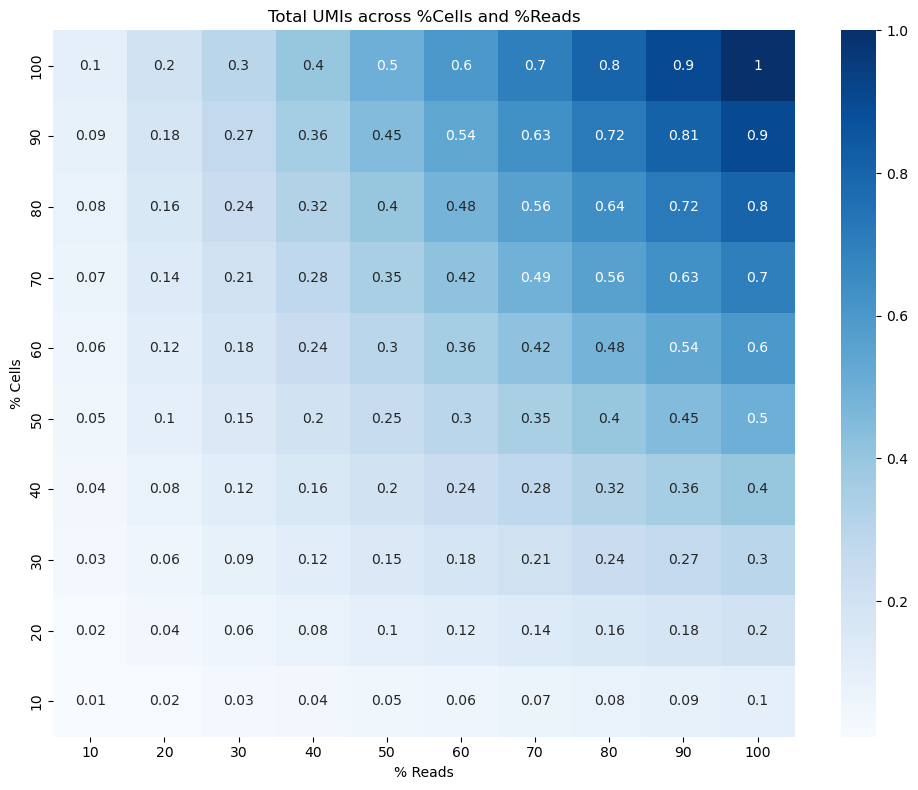

In [13]:
# Split tuple keys into two new columns
summary_df[["cells_frac", "reads_frac"]] = pd.DataFrame(summary_df["sampling_key"].tolist(), index=summary_df.index)

# Strip strings and convert to integers for sorting (optional but recommended)
summary_df["cells_frac"] = summary_df["cells_frac"].str.replace("pct-cells", "", regex=False).astype(int)
summary_df["reads_frac"] = summary_df["reads_frac"].str.replace("pct-reads", "", regex=False).astype(int)
summary_df["umi_percent"] = summary_df["sampled_umis"] / summary_df["umis"].max()

# Pivot table for heatmap
heatmap_data = summary_df.pivot(index="cells_frac", columns="reads_frac", values="umi_percent")
heatmap_data = heatmap_data.sort_index(ascending=False)  # Cells descending (Y axis)
heatmap_data = heatmap_data[sorted(heatmap_data.columns)]  # Reads ascending (X axis)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True,  cmap="Blues")
plt.title("Total UMIs across %Cells and %Reads")
plt.xlabel("% Reads")
plt.ylabel("% Cells")
plt.tight_layout()
plt.show()


And adding created datasets to the config file.

In [14]:
from src.py.beeline_config_utils import init_config, save_config, load_config, add_datasets, toggle_algorithm, set_algorithms, ALL_ALGOS
config_path = beeline_dir / 'config-files' / f"{dataset_name}_config.yaml"
config = load_config(config_path)
add_datasets(config, datasets)
save_config(config, config_path)


Config saved to /home/kl467102/thesis/BEELINE/config-files/buenrostro18_config.yaml
